In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time

## Activation functions

In [2]:
def sigmoid(x):
    """Returns the sigmoid activation for a given variable x"""
    return 1/(1+np.exp(-x))

def tanh(x):
    """Returns the tanH activation for a given variable x"""
    return np.tanh(x)

def cosine(x):
    """Returns the cosine activation for a given variable x"""
    return np.cos(x)

def gaussian(x):
    """Returns the gaussian activation for a given variable x"""
    return np.exp(-((x**2)/2))

## Inputs & Outputs

In [3]:
#Linear
data = np.loadtxt("Data/1in_linear.txt")
x = data[:, :1] # All input variables stored as x
y = data[:, 1:] # All test variables stored as y

## Simplified Neural Network

In [4]:
class NeuralNetwork(object):
    
    def __init__(self):
        """
        The NeuralNetwork object has a fitness attribute that is initialised at infinity
        and will will be updated
        
        The architecture of the network can be adjusted by changing the inputLayerSize,
        outputLayerSize, hiddenlayerSize. 
        
        The Network hyperparameters:
        -----------------------------
        W1: weights from the input layer to the hidden layer. Randomly initialised
        W2: weights from the hidden layer to the output layer. Randomly initialised
        a2_func: activation function of the hidden layer
        yHat_func: activation of the output layer
        b1: input to hidden bias
        b2: hidden to output bias
        
        The Particle Parameters:
        ------------------------
        position: uses the getParams function which yields an array of parameter values
        personal_best_position: is initialised as current position
        personal_best_value: is initialised at infinity
        self.velocity: is initialised at 0 in the shape of the position array
        """
        self.fitness = float("inf")
        
        #Network architecture 
        self.inputLayerSize=1
        self.outputLayerSize=1
        self.hiddenlayerSize=3
        
        #Network hyperparameters
        self.W1 = np.random.randn(self.inputLayerSize, self.hiddenlayerSize)
        self.W2 = np.random.randn(self.hiddenlayerSize, self.outputLayerSize)
        self.a2_func = sigmoid
        self.yHat_func = sigmoid
        self.b1 = random.random()
        self.b2 = random.random()
        
        #Particle parameters
        self.position = self.getParams
        self.personal_best_position = self.position
        self.personal_best_value = float("inf")
        self.velocity = np.zeros(self.getParams.shape)
    
    def move(self):
        """The move function will change the particle position based on particle velocity"""
        self.position = self.position + self.velocity
     
    def __str__(self):
        """Returns a string representation of particle position and network fitness value"""
        return f"Position:{self.position}, Fitness:{self.fitness}"   
    
    def forward(self, X):
        """
        Forward propagation of the neural network 
        z2: is the dot product of input x and W1 plus bias(b1)
        a2: is the activation of the z2
        z3: is the dot product of a2 and W2 plus bias(b2)
        yHat: is the activation of the z3
        """
        self.z2 = np.dot(X, self.W1) + self.b1       
        self.a2 = self.a2_func(self.z2)                 
        self.z3 = np.dot(self.a2, self.W2) + self.b2 
        yHat = self.yHat_func(self.z3)      
        return yHat        
    
    @property
    def getParams(self):
        """Returns the parameters of the neural network in an array that can be used in PSO"""
        array = self.W1.ravel()
        array = np.append(array,self.W2.ravel())
        array = np.append(array,self.b1)
        array = np.append(array,self.b2)
        return array

In [5]:
def mse(predicted, target):
    """
    Mean Squared Error is calculated using the difference of the predicted value(yHat)
    and the target value(y)
    """
    mse = np.square(np.subtract(predicted,target)).mean()
    return mse   

def feedForward(networks):
    """
    The feedForward method loops through a list of networks and input values(x) and
    uses the Neural Network's forward propagation function to calculate a yHat value.
    An error is calculated using the Mean Squared Error function using the target value(y)
    and yHat.
    The error value becomes the network's fitness. 
    """
    for network in networks:
        for col_val_x in x:
            yHat = network.forward(col_val_x)
            for col_val_y in y:
                error = mse(col_val_y,yHat)
            network.fitness = error
    return networks

## PSO

In [6]:
class PSO:
    
    def __init__(self, n_networks):
        """
        The PSO object contains an input n_networks which is the number of neural networks
        that are to be initialised.
        networks: is a list to store the initialised networks
        global_best_value: is initialised as infinity
        global_best_position: gets its shape from the Neural Network's getParams function
        yHat: is initialised at floating point 0. It is needed to plot a graph
        yHat_l: is a list to store the yHat values that is needed to plot a graph
        """
        self.n_networks = n_networks
        self.networks = []
        self.global_best_value = float("inf")
        self.global_best_position = NeuralNetwork().getParams.shape
        self.yHat=0.
        self.yHat_l=[]
    
    def fitness(self, network):
        """Returns the network's fitness value"""
        return network.fitness
    
    def set_personal_best(self):
        """
        The set_personal_best method loops through a list of networks, assisigns a 
        fitness_candidate which is the network's fitness. If the networks' 
        personal_best_value is greater that fitness_candidate; it then assigns the 
        personal_best_value as the fitness_candidate. It then updates the network's
        personal_best_position as the network's position.
        """
        for network in self.networks:
            fitness_candidate = self.fitness(network)
            if(network.personal_best_value > fitness_candidate):
                network.personal_best_value = fitness_candidate
                network.personal_best_position = network.position 
#                     
    def set_global_best(self):
        """
        The set_global_best method loops through a list of networks and assigns the 
        best_fitness_candidate to the network's fitness. If the global_best_value 
        is greater than the best_fitness_candidate the global_best_value is assigned as 
        best_fitness_candidate and the global_best_position becomes the network's position
        """
        for network in self.networks:
            best_fitness_candidate = self.fitness(network)
            if(self.global_best_value > best_fitness_candidate):
                self.global_best_value = best_fitness_candidate
                self.global_best_position = network.position
                
    def move_particles(self):
        """
        The move_particles method contains:
        
        the Intertia weight(W)
        Cognitive(c1)
        Social(c2) weights of the PSO algorithm which can be adjusted.
        
        This method loops through a list of neural networks and stores the product of 
        of interia weight multiplied by network's velocity plus a random number multiplied 
        by the cognitive weight multiplied by the difference of the personal_best_position
        of the network and network's position plus the social weight into a random number
        multiplied by the difference of global_best_position of the networks and network's
        position in a variable called new_velocity. It then assigns the network's velocity
        to this variable and calls the move function from NeuralNetwork class. 
        """
        W = 0.5 # Intertia
        c1 = 0.8 #Cognitive/personal velocity
        c2 = 0.9 # Social velocity
        
        for network in self.networks:
            new_velocity = (W*network.velocity) + (c1*random.random())*\
            (network.personal_best_position - network.position) + \
            (c2*random.random())*(self.global_best_position - network.position)
            network.velocity = new_velocity
            network.move()
    
    def optimise(self):
        """
        The optimise method loops through a list of neural networks and:
        w1: takes the first three numbers from network's position array which is then 
        reshaped to the dimensions of the NeuralNetwork object's W1 parameter
        w2: takes the next three numbers from network's position array which is then 
        reshaped to the dimensions of the NeuralNetwork object's W2 parameter
        b1: takes the 7th item from the array
        b2: takes the 8th item from the array
        
        and uses these variables to forward propagate the neural network with these values.
        z2: is the dot product of input(x) and w1 plus bias(b1)
        a2: is the activation of the z2 using the activation function in NeuralNetwork class
        z3: is the dot product of a2 and W2 plus bias(b2)
        yHat: is the activation of the z3 using the activation function in NeuralNetwork class
        yHat_l: the yHat values are stored in a list for plotting graphs
        error: is calculated by using the Mean Square Error(mse) method using the target value(y)
        and predicted value(yHat). The network's fitness is updated using the error.
        """
        for network in self.networks:
            w1 = network.position[0:3]
            w2 = network.position[3:6]
            w1 = np.reshape(w1,(NeuralNetwork().W1.shape)) 
            w2 = np.reshape(w2,(NeuralNetwork().W2.shape)) 
            b1 = network.position[6:7]
            b2 = network.position[7]
                #Forward
            for col_val_x in x:
                z2 = np.dot(col_val_x, w1) +b1
                a2 = network.a2_func(z2)
                z3 = np.dot(a2, w2) +b2
                self.yHat = network.yHat_func(z3)
                self.yHat_l.append(self.yHat)
                for col_val_y in y:
                    error = mse(col_val_y,self.yHat)
                    network.fitness = error        

In [7]:
num_networks = 10 # Number of networks are to be initialised 
n_iterations = 10 # Number of iterations/epochs that the PSO should run  

pso = PSO(num_networks) # Instantiation of the PSO

# Generates num_networks times NeuralNetwork objects and assigns it to a list 
particles_vector = [NeuralNetwork() for i in range(num_networks)]  

# Forward propagation of all the neural networks
particles_vector = feedForward(particles_vector)

# Assigns the list of neural networks to a list object in PSO class
pso.networks = particles_vector

# The start time to calculate how long the algorithm takes. 
start = time.process_time()

# Sets the number of starting iterations/epochs
iterations = 0

# Initialising a list that stores the errors
error_list = []

# While-loop that continues until total number of iterations or until the global best value = 0
while(iterations < n_iterations) or (pso.global_best_value == 0):
    
    # Starting from the 1st iteration: prints the number of iterations, the global_best_value 
    # and the predicted(yHat) value. Also appends the global_best_value to the error_list
    if iterations!=0:
        print(f"Iteration:{str(iterations)} Error:{pso.global_best_value} yHat:{pso.yHat}")
        error_list.append(pso.global_best_value)
    
    # PSO algorithm is executed by these methods
    pso.set_personal_best()
    pso.set_global_best()    
    pso.move_particles()
    pso.optimise()
    
    # Updates iterations
    iterations +=1

# Prints out the final global_best_position, the total number of iterations, 
# the global_best_value and the time taken to execute the algorithm
print(f"GlobalBest: {pso.global_best_position} iters: {iterations} GlobalBestVal: {pso.global_best_value}")
print(f"------------------------ total time taken: {time.process_time() - start} seconds")       

Iteration:1 Error:0.015147642450047155 yHat:[0.7077475]
Iteration:2 Error:0.015147642450047155 yHat:[0.74787001]
Iteration:3 Error:0.011662095587202053 yHat:[0.83777789]
Iteration:4 Error:0.006853724121371097 yHat:[0.90515994]
Iteration:5 Error:0.00432509493280116 yHat:[0.92941497]
Iteration:6 Error:0.002558845159204057 yHat:[0.93787705]
Iteration:7 Error:0.001774342833635748 yHat:[0.94148951]
Iteration:8 Error:0.001075706767727672 yHat:[0.94540825]
Iteration:9 Error:0.0006322921881298619 yHat:[0.94833576]
GlobalBest: [-3.01821069 -2.49627494  2.88867701  3.72491537 -0.06331467  0.45978504
  1.56963438  1.95519551] iters: 10 GlobalBestVal: 0.0004709203651497017
------------------------ total time taken: 9.078125 seconds


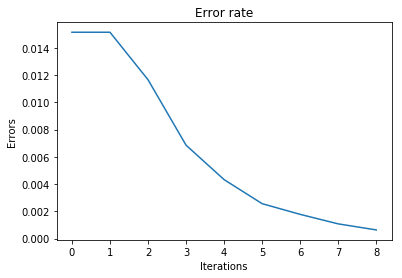

In [8]:
plt.figure()
plt.plot(error_list)
plt.title("Error rate")
plt.xlabel("Iterations")
plt.ylabel("Errors")
plt.show()

10,000 instances of yHats = take every 100

In [9]:
pso.yHat_l
l = pso.yHat_l[0::100]

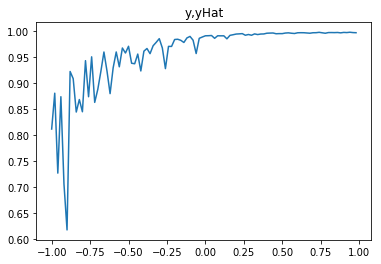

In [13]:
plt.figure()
plt.plot(y,l)
plt.title("y,yHat")
# plt.xlabel("Iterations")
# plt.ylabel("Errors")
plt.show()